# Milestone 2

In [600]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

## Load tables

In [601]:
df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=["wikiID", "plot"])

df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])

df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", "actor_height", "actor_ethnicity",
           "actor_name", "Actor_age", "freeID_char_map", "FreeID_char", "FreeID_actor"])

df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_tropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=["trope", "details"])

## Look at the data

In [602]:
df_plot.head()

,wikiID,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [603]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wikiID  42303 non-null  int64 
 1   plot    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [604]:
df_meta.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [605]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikiID        81741 non-null  int64  
 1   freeID        81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [606]:
df_char.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [607]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WikiID           450669 non-null  int64  
 1   freeID           450669 non-null  object 
 2   release_date     440674 non-null  object 
 3   char_name        192794 non-null  object 
 4   actor_DOB        344524 non-null  object 
 5   actor_gender     405060 non-null  object 
 6   actor_height     154824 non-null  float64
 7   actor_ethnicity  106058 non-null  object 
 8   actor_name       449441 non-null  object 
 9   Actor_age        292556 non-null  float64
 10  freeID_char_map  450669 non-null  object 
 11  FreeID_char      192804 non-null  object 
 12  FreeID_actor     449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [608]:
df_char_names.head()

,char_name,freeID_char_map
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [609]:
df_char_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   char_name        2666 non-null   object
 1   freeID_char_map  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [610]:
df_tropes.head()

,trope,details
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [611]:
df_tropes = df_tropes.drop(["details"], axis=1).join(pd.json_normalize(df_tropes["details"].map(json.loads).tolist())).rename(
    columns={"id":"freeID_char_map"})

In [612]:
df_tropes.head()

,trope,char,movie,freeID_char_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [613]:
df_tropes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   trope            501 non-null    object
 1   char             501 non-null    object
 2   movie            501 non-null    object
 3   freeID_char_map  501 non-null    object
 4   actor            501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


In [614]:
df_tropes.head()

,trope,char,movie,freeID_char_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## Join the dataframes

The feature connecting dataframes together is the Wikipedia ID. Also there are more metadatas of movies (81741 movies) than plots (42303 movies). We will only keep the metadatas of the movies we know the plot of.

In [615]:
df_full = df_meta.merge(df_plot, how='inner', on="wikiID")
df_full.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


Only a small fraction of the characters have been labellised with a trope (500), compared to the number of unlabeled (450669). Here is the dataframe containing the characters with trope

In [616]:
df_inner_char = df_char.merge(df_tropes, how='inner', on='freeID_char_map')

In [617]:
df_inner_char.drop(columns=["char","actor"],inplace=True)
df_inner_char.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor,trope,movie
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Death to Smoochy
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Serenity
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,The Music Man
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue,The Music Man


In [618]:
from xml.dom import minidom

# parse an xml file by name
file = minidom.parse('data/corenlp_plot_summaries/3217.txt.xml')
print(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data/corenlp_plot_summaries/3217.txt.xml'

## Exploratory data analysis

### Genres, languages and countries

In [619]:
def fcount(df):
    df2 = pd.DataFrame(data={
        'id': df.apply(lambda x: list(json.loads(x).keys())),
        'name': df.apply(lambda x: list(json.loads(x).values()))
    })
    
    distinctf = []
    counter = []

    for i in range(df2.shape[0]):
        fid = df2["id"].iloc[i]
        fname = df2["name"].iloc[i]
        for j in range(len(fid)):
            if [fid[j], fname[j]] not in distinctf:
                distinctf.append([fid[j], fname[j]])
                counter.append(1)
            else:
                counter[distinctf.index([fid[j], fname[j]])] += 1
                
    new = pd.DataFrame(data={
        'id': [s[0] for s in distinctf],
        'name': [s[1] for s in distinctf],
        'count': counter
    })
    
    return new.sort_values(by="count", ascending=False, ignore_index=True)

In [620]:
df_genre = fcount(df_meta["genres"])
df_genre.head()

,id,name,count
0,/m/07s9rl0,Drama,34007
1,/m/01z4y,Comedy,16349
2,/m/02l7c8,Romance Film,10234
3,/m/01g6gs,Black-and-white,9094
4,/m/02kdv5l,Action,8798


In [621]:
df_lang = fcount(df_meta["languages"])
df_lang.head()

,id,name,count
0,/m/02h40lc,English Language,40891
1,/m/03k50,Hindi Language,3744
2,/m/06nm1,Spanish Language,3673
3,/m/064_8sq,French Language,3422
4,/m/06ppq,Silent film,3183


In [622]:
df_country = fcount(df_meta["countries"])
df_country.head()

,id,name,count
0,/m/09c7w0,United States of America,34408
1,/m/03rk0,India,8411
2,/m/07ssc,United Kingdom,7868
3,/m/0f8l9c,France,4395
4,/m/03rjj,Italy,3163


### Release date distribution

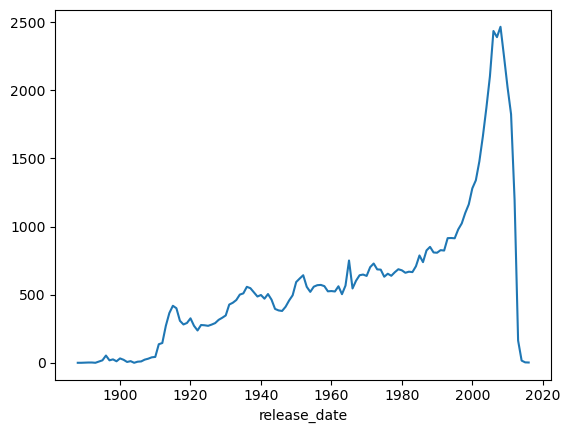

In [623]:
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
df_meta.groupby(df_meta["release_date"].dt.year).count()['wikiID'].plot()
plt.show()

### Runtime distribution

In [624]:
print(df_meta['runtime'].max())

1079281.0


This is strange.

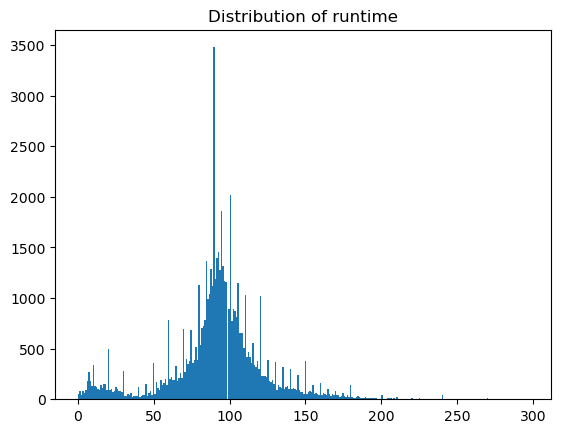

In [625]:
n_bins = 300

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_meta[df_meta['runtime'] < 300]['runtime'], bins=n_bins)
ax.set_title('Distribution of runtime')

plt.show()

### Distribution of number of words in plot description

In [626]:
#use raw plot_summaries and count nb of words in each plot 
df_plot_copy = df_plot.copy()
df_plot_copy['nb_words'] = df_plot_copy['plot'].apply(lambda n: len(n.split()))
df_plot_copy.head(3)

,wikiID,plot,nb_words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",25
1,31186339,The nation of Panem consists of a wealthy Capi...,778
2,20663735,Poovalli Induchoodan is sentenced for six yea...,496


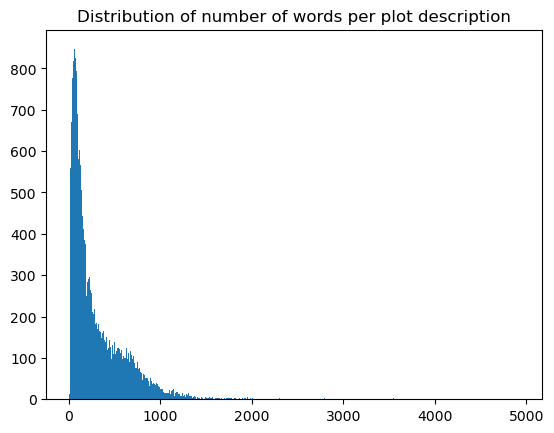

In [627]:
n_bins = 1000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_copy['nb_words'], bins=n_bins)
ax.set_title('Distribution of number of words per plot description')

plt.show()

Only keep the plots with less than 2000 words (which interval?)

In [628]:
threshold = 2000
df_plot_copy = df_plot_copy.loc[df_plot_copy['nb_words'] < threshold]

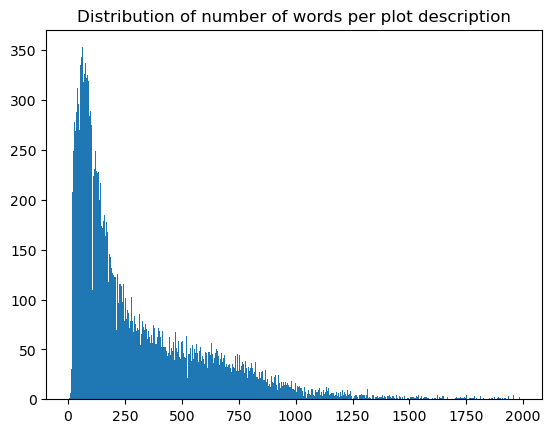

In [629]:
n_bins = 1000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_copy['nb_words'], bins=n_bins)
ax.set_title('Distribution of number of words per plot description')


plt.show()

What would be the minimum number of words to find senseful topic extraction?  

* characters by film distribition: how many characters have been labelised for each film?

In [630]:
df_char_copy = df_char[['freeID','FreeID_actor']].copy()
df_char_copy = df_char_copy.groupby(['freeID']).size().reset_index(name='counts')
df_char_copy.head(5)

,freeID,counts
0,/m/011_mj,9
1,/m/011_p6,5
2,/m/011_zy,4
3,/m/011wtv,18
4,/m/011x_4,20


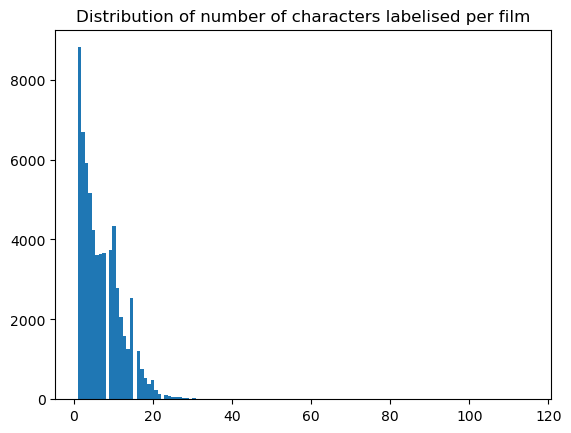

In [631]:
n_bins = 130

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_char_copy['counts'], bins=n_bins)
ax.set_title('Distribution of number of characters labelised per film')

plt.show()

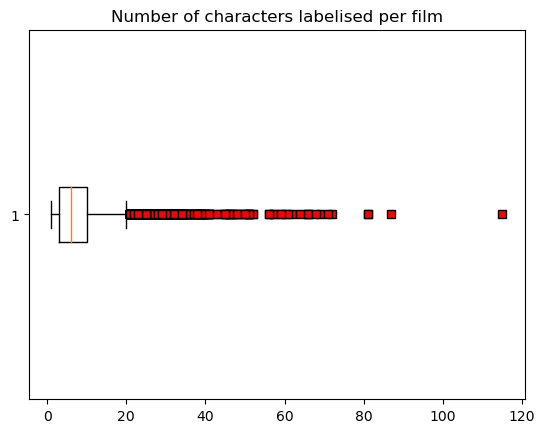

1rst quartile, median and 3rd quartile values: 
0.25     3.0
0.50     6.0
0.75    10.0
Name: counts, dtype: float64


In [632]:
n_bins = 200
red_square = dict(markerfacecolor='r', marker='s')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(df_char_copy['counts'],vert=False, flierprops=red_square)
ax.set_title('Number of characters labelised per film')
plt.show()
print("1rst quartile, median and 3rd quartile values: ")
print(df_char_copy['counts'].quantile([0.25,0.5,0.75]))


"Hemingway & Gellhorn" has more than 115 characters labelised! 

In [664]:
df_char_copy.loc[df_char_copy['counts'] > 100].head(10)

,freeID,counts
46351,/m/0cc8620,115


Preprocessing of metadata dataset : remove films without country, language, genre, runtime, release_date. 
Also remove films with less than nb_min_actors (=1) labeled actors.  

In [666]:
nb_min_actors = 1
#remove Nans
df_char_noNaN = df_char.loc[df_char['char_name'].isna() | (df_char['actor_name'].isna())]
#group by movies the nb of actors labelised by movie
df_clean_char_noNan = df_char_noNaN.groupby(['freeID']).size().reset_index(name='actor count')
#remove the films with less than nb_min_actors
df_clean_char = df_clean_char_noNan.loc[df_clean_char_noNan['actor count'] > nb_min_actors]

print('number of movies remaining after character dataset preprocessing: ', df_clean_char.shape[0])

number of movies remaining after character dataset preprocessing:  43794


In [674]:
df_inner_meta = df_meta.merge(df_clean_char, how='inner', on='freeID')

df_clean = df_inner_meta.loc[(df_inner_meta['countries'] != '{}') & (df_inner_meta['languages'] != '{}') & (df_inner_meta['genres'] != '{}') &
            df_inner_meta['release_date'].notnull()].reset_index()
    
print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

number of movies remaining after movie metadata preprocessing:  35924


In [668]:
df_clean = df_clean.merge(df_plot, how='inner', on='wikiID')

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

number of movies remaining after movie metadata preprocessing:  23319


In [669]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23319 entries, 0 to 23318
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         23319 non-null  int64         
 1   wikiID        23319 non-null  int64         
 2   freeID        23319 non-null  object        
 3   name          23319 non-null  object        
 4   release_date  23319 non-null  datetime64[ns]
 5   revenue       4382 non-null   float64       
 6   runtime       21244 non-null  float64       
 7   languages     23319 non-null  object        
 8   countries     23319 non-null  object        
 9   genres        23319 non-null  object        
 10  actor count   23319 non-null  int64         
 11  plot          23319 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 2.3+ MB


By observing the non-null counts, on the runtime and revenue columns, we decided to eliminate these attributes. 

In [670]:
df_clean.drop(columns=['revenue','runtime','index'], inplace=True)

Right formatting for next data analysis steps:

In [671]:
df_clean['countries'] = pd.DataFrame(data={
        #'id': df_clean['countries'].apply(lambda x: list(json.loads(x).keys())),
        'countries': df_clean['countries'].apply(lambda x: list(json.loads(x).values()))
    })
df_clean['languages'] = pd.DataFrame(data={
        #'id': df_clean['countries'].apply(lambda x: list(json.loads(x).keys())),
        'languages': df_clean['languages'].apply(lambda x: list(json.loads(x).values()))
    })
df_clean['genres'] = pd.DataFrame(data={
        #'id': df_clean['countries'].apply(lambda x: list(json.loads(x).keys())),
        'genres': df_clean['genres'].apply(lambda x: list(json.loads(x).values()))
    })    

Preprocessed dataset:

In [673]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23319 entries, 0 to 23318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wikiID        23319 non-null  int64         
 1   freeID        23319 non-null  object        
 2   name          23319 non-null  object        
 3   release_date  23319 non-null  datetime64[ns]
 4   languages     23319 non-null  object        
 5   countries     23319 non-null  object        
 6   genres        23319 non-null  object        
 7   actor count   23319 non-null  int64         
 8   plot          23319 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.8+ MB


Every columns has the same number of non-null values, and there isn't any null value inside of it. 

## CoreNLP

In [640]:
import gzip
import os

path = "data/corenlp_plot_summaries/"
files = os.listdir(path)
print(files[0])
f = gzip.open(path+files[0], 'rb')

test = f.read().decode()
# print(test)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/corenlp_plot_summaries/'

In [ ]:
from bs4 import BeautifulSoup

Bs_data = BeautifulSoup(test, "xml")
 
print(Bs_data.find("sentence", {'id':'20'}).find('NER').text)

## Choice of attributes based on data exploratory analysis

## Methods to study similarities accross chosen attributes

### 1. Mathematical similarity definition

#### 1.1 Cosine similarity
$$
cosine \: similarity(A,B)=S_c(A,B)=cos(\theta)=\frac{A.B}{\|A\| \|B\|}=\frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i}\sqrt{\sum_{i=1}^{n} B_i}}
$$
Where $A,B \in \mathbb{R}^n$, $S_c(A,B) \in [-1,1]$ where -1 means that the two vectors are exactly opposite, and 1 means that they are exactly similar and 0 means that they are orthognonal which shows decorrelation.

#### 1.2 Centered Cosine similarity
$$
centered \: cosine \: similarity(A,B)=\frac{(A-\overline{A}).(B-\overline{B})}{\|A-\overline{A}\| \|B-\overline{B}\|}
$$
Where A and B have been normalized before by substracting their mean.

#### 1.3 Associated distance with cosine similarity
- **Angular distance**

if $A_i,B_i \in \mathbb{R}$ 
$$
angular \: distance=D_\theta=\frac{arccos(S_c(A,B))}{\pi}=\frac{\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{\theta}{\pi}
$$
if $A_i,B_i \in \mathbb{R}$ and $A_i,B_i\geq 0$
$$
angular \: distance=D_\theta=\frac{2.arccos(S_c(A,B))}{\pi}=\frac{2\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{2\theta}{\pi}
$$
Where the angular distacne is a formal distance metric, however the arccos computation cost makes it more computationally expensive and slower.

- **Cosine distance**

$$
cosine \: distance=D_c=1-S_c(A,B)
$$
Where the cosine distance is an unformal distance metric (it does not respect the triangle inequality or Schwarz inequality) but it is less computationally expensive.


- **L2-normalized Euclidean distance**

From the L2 distance defined as followed: $ \|x\|_2=\sqrt{\sum x_i^2}=\sqrt{x.x} $ and the euclidean distance defined as followed: 
$ d(A,B)=|A-B|=\sqrt{\sum _{i=1}^{n} (A_i-B_i)^2 } $, we get the L2-normalized Euclidean distance:
$$
L2-normalized \: Euclidean \: distance=\sqrt{\sum _{i=1}^{n} (A_i'-B_i')^2} \quad \textrm{where} \quad A'=\frac{A}{\|A\|_2}
$$

The cosine similarity and associated distances reflects relative rather than absolute comparison of vectors. For example vectors $A$ and $\alpha A$ where $\alpha \in \mathbb{R}$ are maximally similar. Therefore this similarity is appropriate for data where frequency is more important than absolute value. For text comparison it can be very useful, we could compare the frequency of terms in a document.  

#### 1.4 Soft cosine similarity
$$
soft \: cosine \: similarity(A,B)=\frac{\sum_{i,j}^{n}s_{ij}A_iB_j}{\sqrt{\sum_{i,j}^{n} s_{ij}A_iA_j}\sqrt{\sum_{i,j}^{n} s_{ij}B_iB_j}}
$$
where $s_{ij}$=similarity($feature_i$,$feature_j$). For example if $s_{ii}$=1 and $s_{ij}$=0 $\forall i\neq j$ then there is no similarity between features, then the soft cosine similarity is equal to the cosine similarity. In the case where features are words, the matrix $S$ has to define the similarity between words.

### 2. Algorithm to study similarity between movies attributes

#### tf-idf : Term frequency-inverse document frequency
**Term frequency and Inverse document frequency**

$$
tf(t,d)=\frac{f_{t,d}}{ \sum_{t' \in d} f_{t',d} } \quad \textrm{and} \quad idf(t,D)=log(\frac{N}{|d\in D:t\in d|})
$$
where $f_{t,d}$ = raw frequency = number of times a term $t$ occurs in document $d$, $ \sum_{t' \in d} f_{t',d}$=total number of terms $t'$ in $d$ by suming each independent occurrence
<br>
where $N$=$|D|$= number of documents in corpus $D$, $|d\in D:t\in d|$= number of documents where t appears (where $tf(t,d)\neq 0$)

To prevent bias towards longer documents, the term frequency can be computed as follow:
$$
tf(t,d)=0.5+0.5\frac{f_{t,d}}{max(f_{t',d}:t'\in d)}
$$
To avoid divinding by zero, the idf denominator can ba adjusted as follow:
$$
idf(t,D)=log(\frac{N}{1+|d\in D:t\in d|})
$$
**Term frequency-inverse document frequency**

From the term frequency and the inverse document frequency we can compute the tf-idf:
$$
tf-idf(t,D)=tf(t,d).idf(t,D)
$$

The tf-idf reflects how important a word is to a document in corpus. tf-idf increase proportionally with the number of times a word appear in a document, but it is offset by the number of documents in the corpus that contains the word. It is high when there is high term frequency in document d **and** low document frequency of the term in the whole corpus. This helps to adjust the fact that some words appear more frequently that we can define as common terms. It tends to filter out those common words.

**Implementation**

tfidf can be implemented using the `GenSim` opensource library. After obtaining tf-idf associated for each word in each text, we can compute the cosine similarity between those texts. Since we compare to what extent different movies contain the exact same words, we need to add a lemmatizer filtering to take care of the same words being in the singular or plural form.
xxx

**Movie Attribute similarity that can be studied**
- Movie genre
- Movie Language ¨
- Actor
- Characters 
- Movie Country??? xxx
- Director??? xxx 

Here we can use this method for these attributes because we want to find which of those attributes contain the exact same words and study the similarity based on this analysis. 

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

#### Preprocessing method on a document corpus before topic extraction

Here is a preprocessing approach that can be implemented before using a topic extraction analysis
1. Removing the stop words from the documents which are the most common words occuring in texts that give no additional concept. It can be done with `Java` using `MySQL`.
2. Removing the numbers appart from years, the non-asci characters, and most common occuring names (ex: James, Robert, John)
3. Handle pural and singular form of the same word by lemmatizing.
4. We can filter the words using tf-idf. We can compute the tf-idf for each word of each plot and keep the words with highest tf-idf score. The threshold for a word to be kept has to be defined.

#### LDA: Latent Dirichlet Allocation

<div>
<img src="images/LDA_example.png" width="800"/>
</div>

**Definition**

LDA is an algorithm that can be used for topic extraction in texts. It is an unsupervised machine-learning model that takes documents as input and finds topics as output. A topic is represented as a weighted list of words. The model also says in what percentage each document talks about each topic. 

**Implementation**

LDA can be implemented using the `GenSim` library. When using LDA to analyse topics in a corpus, it needs some preprocessing steps before applying the algorithm to make it more efficient. We detailed one preprocessing approach above.


After this processing we can apply LDA on our database by tuning some parameters:
<br>
$K$: the number of topics we look for
<br>
$\alpha$: K-dimension vector of positive reals that represent the prior weights of topic K in a document which affects the document-topic distribution. 
<br>
$\eta$: V-dimension vector of positive reals that represents the prior weights of each words in topics which affects the topic-word distribution

If we chose a symetric LDA, the weights $\alpha$ would be the same for all topics and the weights $\eta$ would be the same for all words in a topic. The smaller the $\alpha$ the fewer topics per document, the fewer the $\eta$ the fewer words per topic.

**Movie Attribute similarity that can be studied**
- Plot

#### Doc2Vec topic extraction
**Definition**

Doc2Vec is an unsupervised algorithm that learns fixed-length feature vectors for paragraphs/documents/texts. Then we can compare these vectors to assess the similarity between documents. Doc2vec allows to generate a semantic space which is a spatial space where distance among vectors are indicator of semantic similarity. This semantic space consisting of word and document vectors is a continuous representation of topics, unlike LDA where topics are sampled from a discrete space. It means that the dense areas having high concentration of document can be thought of having similar topics and can be best represented by nearby embedded words.

**Implementation**

It can be implemented using the `GenSim` library with the class `Doc2Vec` that extends the class `Word2Vec`. 


**Movie Attribute similarity that can be studied**
- Plot

#### Release year similarity algorithm to add xxx

### 3. Assessing the global similarity between movies taking into account all attributes

#### Finding weights between attributes, to make the global similarity depending more or less on specific attributes

xxx

#### Method to merge all attributes similarities together

xxx

## Visualization method

### t-SNE
**Definition**

**Implementation**

`scikit-learn` library

### Other??

## User Recommandation method

### k-Nearest Neighbors
**Definition**

**Implementation**

`scikit-learn` library
<br>
tensorboard associated with `TensorFlow` library

### Other???